In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
# from Plot_XZ import *
from PCA import *

In [2]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])

# #特征因素分析
elec_tem = elec_data.Tem.values + SNR[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# data_cs_year[42:45] = 12
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
# elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')
# elec_Pca_char3 = elec_Pca1[:, 2] # 降维特征2
print(elec_Pca_char1)
print('\n')
print(elec_Pca_char2)
elec_data.Fault.values[48] =2000
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)
# elec_faults[25] = 3
# elec_faults[39] = 5
# elec_faults[53] = 3.8
# print(elec_faults)
# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(data_cs_year))
Num_shared = shared(np.asarray(companyABC))

[ 3.  3.  3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  2.  2.  3.  3.  3.  3.  2.  3.  3.  3.  2.  3.  3.  3.  3.  3.  3.  3.
  2.  3.  3.  3.  3.  2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.
 -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -0. -0. -0. -0. -0. -1.
 -0. -0. -0. -0. -0. -0. -0. -1. -0. -0. -1. -1. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -1. -0. -1. -0. -0. -0. -0. -0. -0. -1.]


[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.

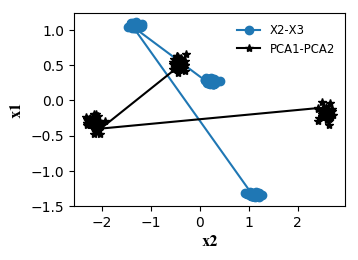

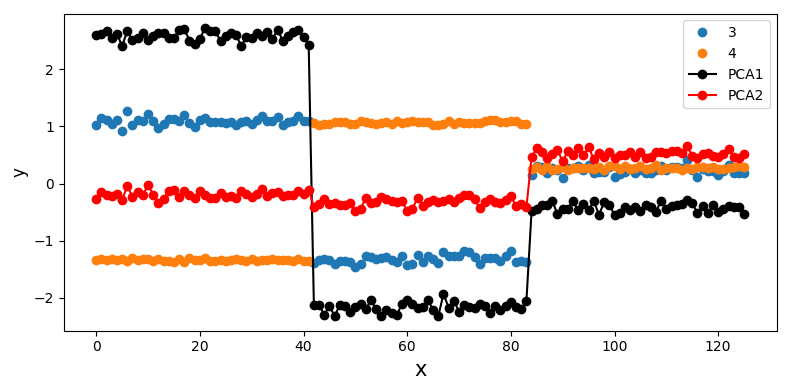

In [3]:
from matplotlib import gridspec
# 最后两个变量因素的主成分最大。故只画出最后两个的图
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
fig = plt.figure(figsize=(3.5, 2.5))
gs = gridspec.GridSpec(1, 1)
ip=0
ax = plt.subplot(gs[ip])
# for i in np.arange(3):
# ax.plot(elec_Pca[:, 2],elec_Pca[:, 0],'o')
# ax.plot(elec_Pca[:, 2],elec_Pca[:, 1],'o')
ax.plot(elec_Pca[:, 2],elec_Pca[:, 3],'o-')
# ax.plot(elec_Pca[:, 0],elec_Pca[:, (i+1)],'o')

ax.plot(elec_Pca1[:, 0], elec_Pca1[:, 1], 'k*-')
plt.legend([ 'X2-X3', 'PCA1-PCA2'], loc='upper right',frameon=False, fontsize='small')
    
plt.xlabel('x2', fontdict=font1)
plt.ylabel('x1', fontdict=font1)
# Savefig = 1
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\corr.svg', format='svg')
plt.show()


fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 1)
for ip in np.arange(1):
    ax = plt.subplot(gs[ip])
    for i in np.arange(2):
        ax.plot(elec_Pca[:, (i+2)],'o')

    ax.plot(elec_Pca1[:, ip], 'ko-')
    ax.plot(elec_Pca1[:, ip+1], 'ro-')
    plt.legend([ '3', '4', 'PCA1','PCA2'], loc='upper right')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=12)
plt.tight_layout()
plt.show()

In [4]:
tmp2 = np.loadtxt('summary1.csv',delimiter = ',')
trace_2b = np.loadtxt('trace_yl2.csv',delimiter = ',')
tracemocon_yl2 = np.loadtxt('tracemocon_yl2.csv',delimiter = ',')
# print(tmp2[:, 0])
betaMAP2 = tmp2[0, 0]
beta1MAP2 = tmp2[np.arange(companiesABC) + 1,0]
beta2MAP2 = tmp2[np.arange(companiesABC) + 1*companiesABC+1,0]
beta3MAP2 = tmp2[np.arange(companiesABC) + 2*companiesABC+1,0]
beta4MAP2 = tmp2[np.arange(companiesABC) + 3*companiesABC+1,0]
uMAP2 = tmp2[13,0]
elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')


In [5]:
# 应用偏最小二乘PLS来进行仿真
from sklearn.cross_decomposition import PLSRegression
X_PLSR = np.vstack((elec_year, elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
X_PLSR_XZ = X_PLSR[:42, :]
X_PLSR_XJ = X_PLSR[42:84, :]
X_PLSR_HLJ = X_PLSR[84:, :]
# X_PLSR_HLJ[:5, 0]=7
# print(X_PLSR_HLJ)
Y_PLSR = elec_faults
Y_PLSR_XZ = Y_PLSR[:42]
Y_PLSR_XJ = Y_PLSR[42:84]
Y_PLSR_HLJ = Y_PLSR[84:]
# print(Y_PLSR_XZ)


pls_XZ = PLSRegression(n_components=2)
pls_XZ.fit(X_PLSR_XZ, Y_PLSR_XZ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XZ = pls_XZ.predict(X_PLSR_XZ)
Y_PLSpred_XZ =  np.vstack((Y_PLSpred_XZ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XZ)

pls_XJ = PLSRegression(n_components=2)
pls_XJ.fit(X_PLSR_XJ, Y_PLSR_XJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_XZ, Y_PLSR_XZ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_XJ = pls_XJ.predict(X_PLSR_XJ)
Y_PLSpred_XJ =  np.vstack((Y_PLSpred_XJ).T)[0]
# print(X_train_r)
# print(Y_PLSpred_XJ)


pls_HLJ = PLSRegression(n_components=2)
pls_HLJ.fit(X_PLSR_HLJ, Y_PLSR_HLJ)
# X_train_r, Y_train_r = pls_XZ.transform(X_PLSR_HLJ, Y_PLSR_HLJ)
# PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)
Y_PLSpred_HLJ = pls_HLJ.predict(X_PLSR_HLJ)
Y_PLSpred_HLJ =  np.vstack((Y_PLSpred_HLJ).T)[0]
# print(Y_PLSpred_HLJ)
# print(Y_train_r)

Y_PLSpred = np.vstack((Y_PLSpred_XZ, Y_PLSpred_XJ, Y_PLSpred_HLJ))# Pls预测值
Y_PLSpred_Target = np.vstack((Y_PLSR_XZ, Y_PLSR_XJ, Y_PLSR_HLJ)) # 目标值
# print(Y_PLSpred)
# print(Y_PLSpred)

aaa = pls_HLJ.get_params(deep=True) # 获取参数
print(aaa)

{'copy': True, 'max_iter': 500, 'n_components': 2, 'scale': True, 'tol': 1e-06}


[[ 0.  0.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  1.]]


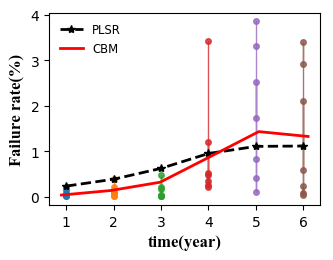

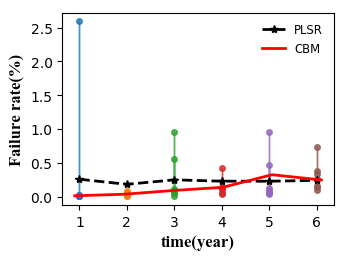

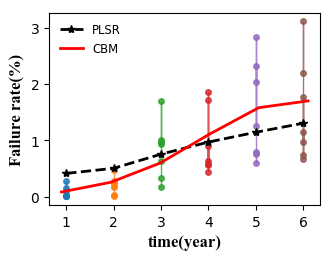

In [6]:
# 将预测值转化为均值形式
AAA = np.array([Y_PLSpred_XZ[i*6:(i+1)*6] for i in np.arange(7)])
BBB = np.array([Y_PLSpred_XJ[i*6:(i+1)*6] for i in np.arange(7)])
CCC = np.array([Y_PLSpred_HLJ[i*6:(i+1)*6] for i in np.arange(7)])
XZ_mean = AAA[:].mean(axis=0)
XJ_mean = BBB[:].mean(axis=0)
HLJ_mean = CCC[:].mean(axis=0)
Y_PLSpred_MEAN = np.vstack((XZ_mean, XJ_mean, HLJ_mean))# Pls预测值
print(Y_PLSpred_MEAN)
# print(HLJ_mean)
plt.figure(figsize=(3.5, 2.5), facecolor='w')
xipred = np.array(np.arange(6) + 1)
Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']

# for ip in np.arange(3):
ip=0
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=0.8, markersize=4, linewidth=1)

yipred_yplot = np.array(Y_PLSpred_MEAN[ip])
ax1, = ax.plot(xipred, yipred_yplot, '*--', color='k', linewidth=2)
    
xl = np.linspace(0.9, 6.1, 6)   
y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))  
ax2, = plt.plot(xl, y2,  'r', linewidth=2)

plt.xlabel("time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2], ['PLSR', 'CBM'], loc='upper left', frameon=False, fontsize='small')
Savefig = 0
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSR0.svg', format='svg')
plt.show()

plt.figure(figsize=(3.5, 2.5), facecolor='w')
# for ip in np.arange(3):
ip=1
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=0.8, markersize=4, linewidth=1)

yipred_yplot = np.array(Y_PLSpred_MEAN[ip])
ax1, = ax.plot(xipred, yipred_yplot, '*--', color='k', linewidth=2)
    
xl = np.linspace(0.9, 6.1, 6)   
y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))  
ax2, = plt.plot(xl, y2,  'r', linewidth=2)

plt.xlabel("time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2], ['PLSR', 'CBM'], loc='upper right', frameon=False, fontsize='small')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSRjpg1.jpg', dpi = 300)
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSR1.svg', format='svg')
plt.show()

plt.figure(figsize=(3.5, 2.5), facecolor='w')
# for ip in np.arange(3):
ip=2
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=0.8, markersize=4, linewidth=1)

yipred_yplot = np.array(Y_PLSpred_MEAN[ip])
ax1, = ax.plot(xipred, yipred_yplot, '*--', color='k', linewidth=2)
    
xl = np.linspace(0.9, 6.1, 6)   
y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))  
ax2, = plt.plot(xl, y2,  'r', linewidth=2)

plt.xlabel("time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2], ['PLSR', 'CBM'], loc='upper left', frameon=False, fontsize='small')

if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSR2.svg', format='svg')
plt.show()

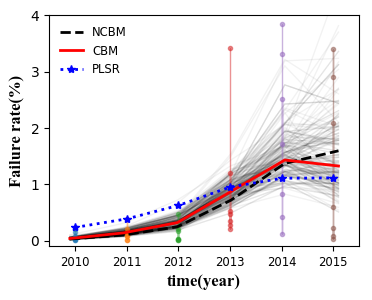

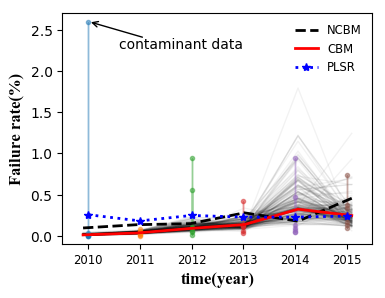

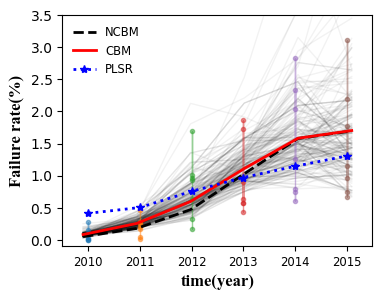

In [7]:
xipred = np.array(np.arange(6) + 1)
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
fig = plt.figure(figsize=(4, 3) )
font1 ={'family': 'times new roman', 'weight':'normal', 'size': 12}  
ppcsamples = 200

ip=0
# for ip in np.arange(companiesABC):
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip*7:(ip+1)*7, :]
yp = elec_faults2[ip*7:(ip+1)*7, :]
    
xl = np.linspace(0.9, 6.1, 6)

y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))   
    # Posterior sample from the trace
for ips in np.random.randint(ip*500, (ip+1)*500, ppcsamples):
    yl2 = trace_2b[ips]
    ax.plot(xl, yl2, 'k', linewidth=1, alpha=.05)

yipred_yplot = np.array(Y_PLSpred_MEAN[ip])
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
ax.plot(xp, yp, marker='o', alpha=0.5, markersize=3, linewidth=1)
ax1, = plt.plot(xl, tracemocon_yl2[ip], 'k--', linewidth=2)
ax2, = plt.plot(xl, y2,  'r', linewidth=2)
ax3, = ax.plot(xipred, yipred_yplot, '*:', color='b', linewidth=2)
plt.axis([0.5, 6.5, -.1, 4])
ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
plt.xlabel("time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2, ax3], ['NCBM', 'CBM','PLSR'], loc='upper left', frameon=False, fontsize='small')
Savefig = 0

if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\CBM0.svg', format='svg')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSRjpg.png', dpi = 200, bbox_inches='tight')
plt.show()



fig = plt.figure(figsize=(4, 3))
ip=1
# for ip in np.arange(companiesABC):
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip*7:(ip+1)*7, :]
yp = elec_faults2[ip*7:(ip+1)*7, :]
    
xl = np.linspace(0.9, 6.1, 6)

y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))   
    # Posterior sample from the trace
for ips in np.random.randint(ip*500, (ip+1)*500, ppcsamples):
    yl2 = trace_2b[ips]
    ax.plot(xl, yl2, 'k', linewidth=1, alpha=.05)
    
yipred_yplot = np.array(Y_PLSpred_MEAN[ip])
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
ax.plot(xp, yp, marker='o', alpha=0.5, markersize=3, linewidth=1)
ax1, = plt.plot(xl, tracemocon_yl2[ip], 'k--', linewidth=2)
ax2, = plt.plot(xl, y2,  'r', linewidth=2)
ax3, = ax.plot(xipred, yipred_yplot, '*:', color='b', linewidth=2)
plt.axis([0.5, 6.5, -.1, 2.7])
plt.xlabel("time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2, ax3], ['NCBM', 'CBM','PLSR'], loc='upper right', frameon=False, fontsize='small')
label_f1 = "contaminant data"
ax.text(4,2.4,label_f1,fontsize=10,verticalalignment="top",horizontalalignment="right")
ax.annotate('',xy=(1,2.6),xytext=(2.1,2.4),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

ax.set_xticklabels(['2010','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSRjpg1.png', dpi = 200, bbox_inches='tight')
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\CBM1.svg', format='svg')
plt.show()

fig = plt.figure(figsize=(4, 3))
ip=2
# for ip in np.arange(companiesABC):
ax = plt.subplot(1, 1, 1)
xp = elec_year2[ip*7:(ip+1)*7, :]
yp = elec_faults2[ip*7:(ip+1)*7, :]
    
xl = np.linspace(0.9, 6.1, 6)

y2 = np.exp(uMAP2 + betaMAP2 + (beta1MAP2[ip]*xl + beta2MAP2[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                beta3MAP2[ip]*elec_Pca_char2[ip*42:(ip*42+6)] + beta4MAP2[ip]*xl*xl))   
    # Posterior sample from the trace
for ips in np.random.randint(ip*500, (ip+1)*500, ppcsamples):
    yl2 = trace_2b[ips]
    ax.plot(xl, yl2, 'k', linewidth=1, alpha=.05)
    
yipred_yplot = np.array(Y_PLSpred_MEAN[ip])
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
ax.plot(xp, yp, marker='o', alpha=0.5, markersize=3, linewidth=1)
ax1, = plt.plot(xl, tracemocon_yl2[ip], 'k--', linewidth=2)
ax2, = plt.plot(xl, y2,  'r', linewidth=2)
ax3, = ax.plot(xipred, yipred_yplot, '*:', color='b', linewidth=2)
plt.axis([0.5, 6.5, -.1, 3.5])
ax.set_xticklabels(['2010','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
plt.xlabel("time(year)", fontdict=font1)
plt.ylabel("Failure rate(%)", fontdict=font1)
plt.legend([ax1, ax2, ax3], ['NCBM', 'CBM','PLSR'], loc='upper left', frameon=False, fontsize='small')
plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\PLSRjpg2.png', dpi = 200, bbox_inches='tight')
if Savefig == 1:
    plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\CBM2.svg', format='svg')

plt.show()

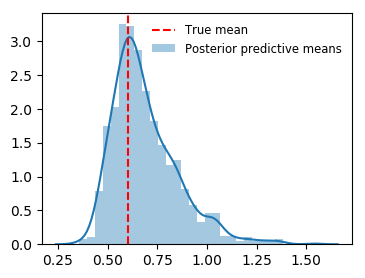

In [8]:
plt.style.use('default')
elec = pd.read_csv('ppcObserved_mean_1.csv')
plt.figure(figsize=(4, 3))
ax = sns.distplot(elec, label='Posterior predictive means') # axis=1以行方式计算
ax.axvline(elec_faults.mean(), color='r', ls='--', label='True mean')
ax.legend(frameon=False, fontsize='small')

plt.show()

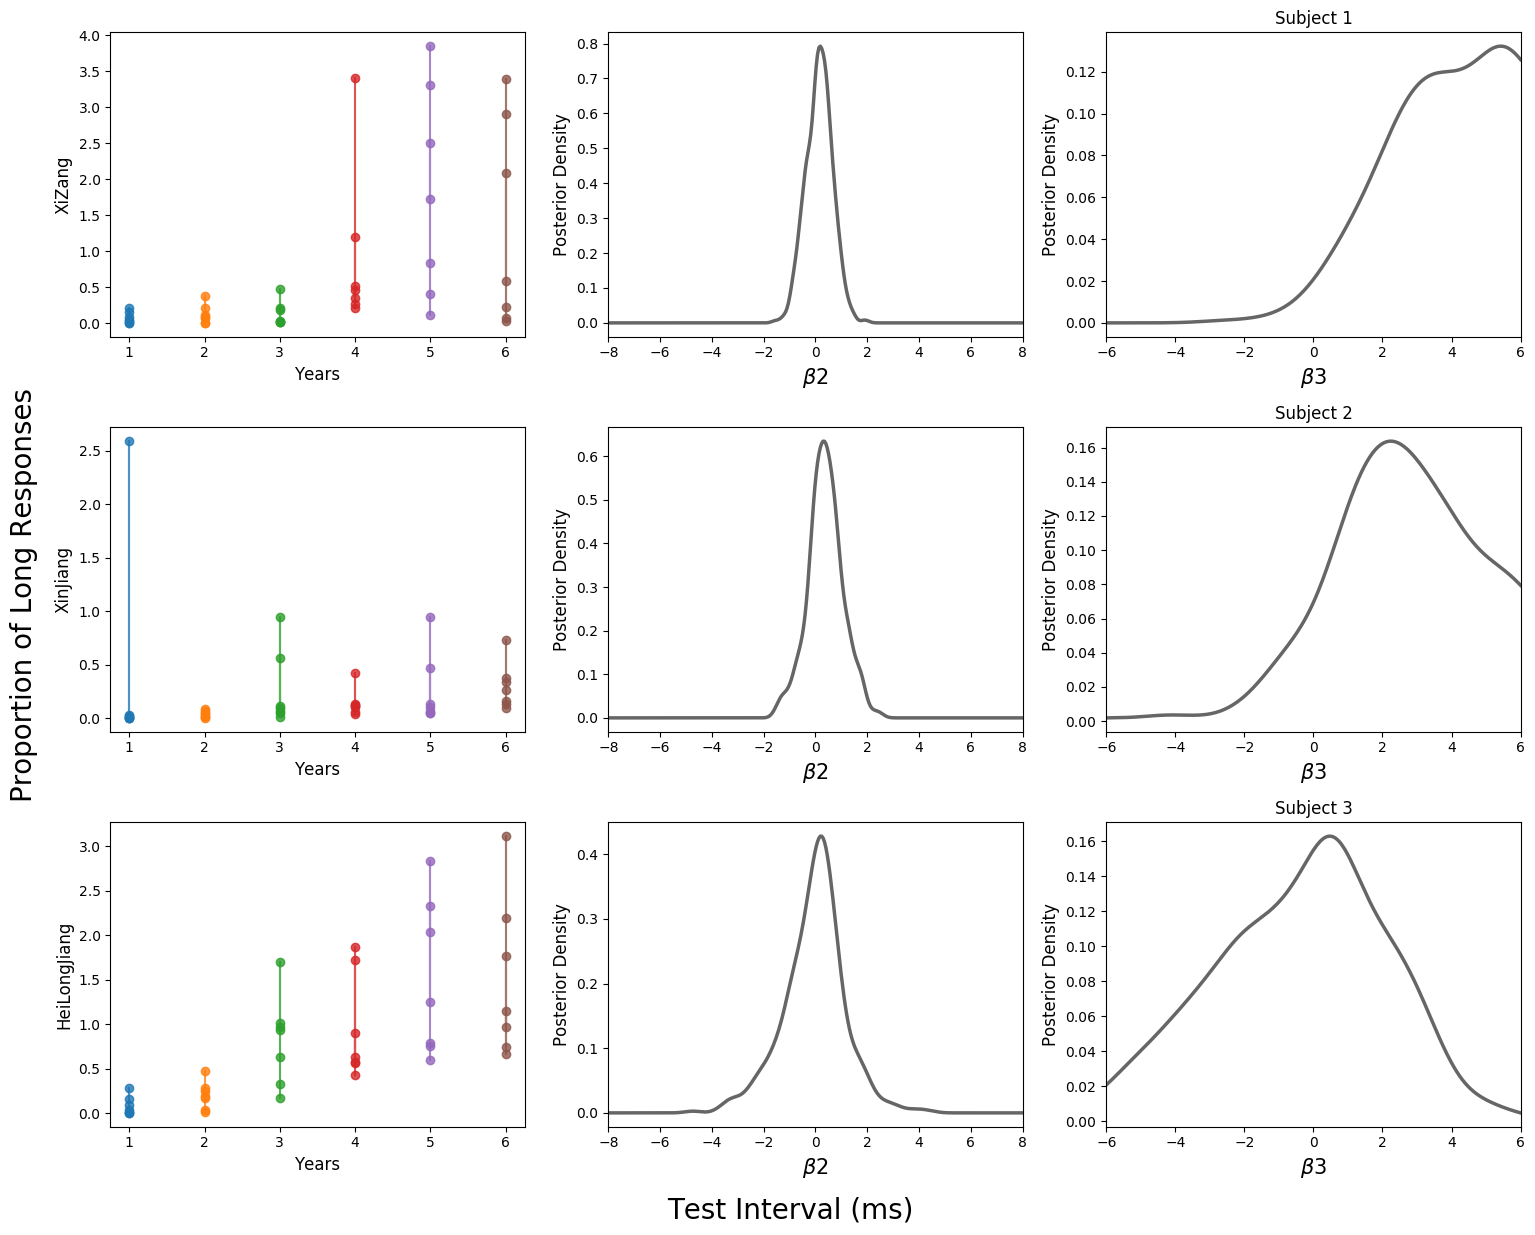

In [9]:
# 跟随特征变化分析
from scipy.stats.kde import gaussian_kde
burnin = 2000
# kde_beta2 = trace_2b['beta2'][burnin:]
# kde_beta3 = trace_2b['beta3'][burnin:]
kde_beta2 = np.loadtxt('kde_beta2.csv',delimiter = ',')
kde_beta3 = np.loadtxt('kde_beta3.csv',delimiter = ',')


fig = plt.figure(figsize=(15, 12))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(3, 3)
ppcsamples = 100
burnin = 2000

ylabes = ['XiZang', 'XinJiang', 'HeiLongJiang']

for ip in np.arange(companiesABC):
    ax0 = plt.subplot(gs[ip*3])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    ax0.plot(xp, yp, marker='o', alpha=.8)
    plt.ylabel(ylabes[ip], fontsize=12)
    plt.xlabel('Years' , fontsize=12)
    
    x0 = np.linspace(0.5, 6, 6)
#     y0 = np.exp(uMAP + betaMAP + beta1MAP[ip]*xl + beta2MAP[ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
#                 beta3MAP[ip]*elec_Pca_char2[ip*42:(ip*42+6)] ++ beta4MAP[ip]*xl*xl)
    
    # Posterior sample from the trace
#     for ips in np.random.randint(burnin, 3000, ppcsamples):
#         param = trace[ips]
#         yl2 = np.exp(param['beta'][ip] + param['beta1'][ip] * (xl) + param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+40)] + \
#                      param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+40)])
#         ax0.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
    ax1 = plt.subplot(gs[1+ip*3])
    my_pdf1 = gaussian_kde(kde_beta2[:, ip])
    x1 = np.linspace(-8, 8, 300)
    ax1.plot(x1, my_pdf1(x1), 'k', lw=2.5, alpha=0.6)
    plt.xlim((-8, 8))
    plt.xlabel(r'$\beta2$', fontsize=15)
    plt.ylabel('Posterior Density', fontsize=12)
    
    ax2 = plt.subplot(gs[2+ip*3])
    my_pdf2 = gaussian_kde(kde_beta3[:, ip])
    x2 = np.linspace(-6, 6, 300)
    ax2.plot(x2, my_pdf2(x2), 'k', lw=2.5, alpha=0.6)
    plt.xlim((-6, 6))
    plt.xlabel(r'$\beta3$', fontsize=15)
    plt.ylabel('Posterior Density', fontsize=12)
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

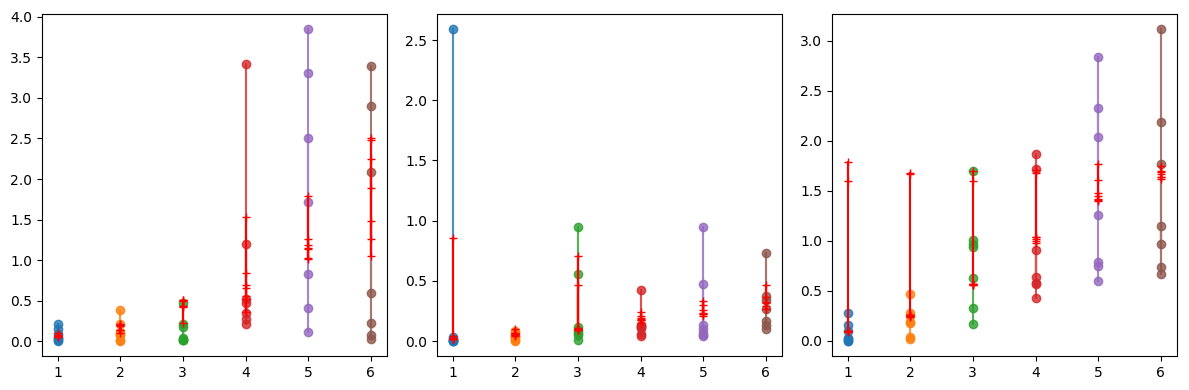

In [10]:
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据

yipred_mean = np.loadtxt('yipred_mean.csv',delimiter = ',')
xipred={}

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
    yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
    ax.plot(xp, yp, marker='o', alpha=.8)
    
    yipred_yplot = np.array([yipred_mean[i*6:(i+1)*6] for i in np.arange(7*ip, (ip+1)*7)])
    xipred = np.array([np.arange(6)+1 for i in np.arange(7)])
    ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')
    
plt.tight_layout()
plt.show()

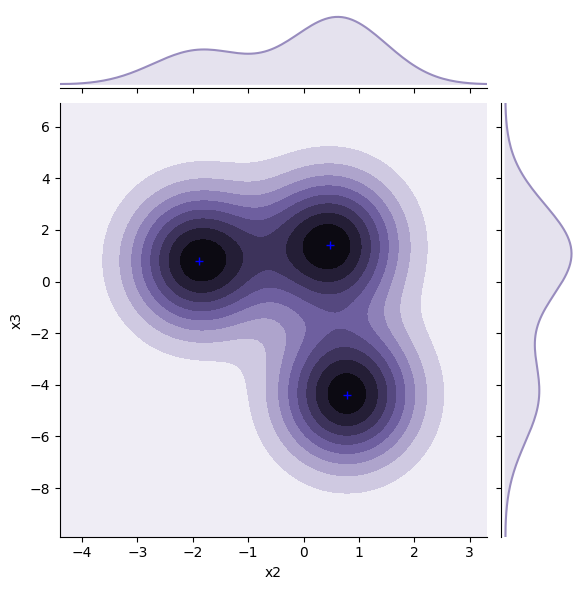

In [11]:
# 两个特征值的联合后验
fig = plt.figure(figsize=(4, 3))
trace_beta2 = np.loadtxt('trace_beta2.csv',delimiter = ',')
trace_beta3 = np.loadtxt('trace_beta3.csv',delimiter = ',')
# datamap = np.vstack((trace_beta2[:, 1], trace_beta3[:,1]))
datamap = np.vstack((trace_beta2[1], trace_beta3[1]))
df = pd.DataFrame(datamap.transpose(), columns=["x2", "x3"])
g = sns.jointplot(x="x2", y="x3", data=df, kind="kde", color="#988CBE", stat_func=None, xlime=(-2,2), ylime=(-2,2))
g.plot_joint(plt.scatter, c="b", s=40, linewidth=1, marker="+")
plt.show()

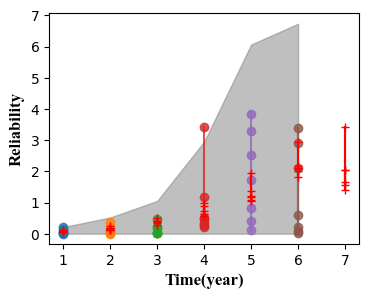

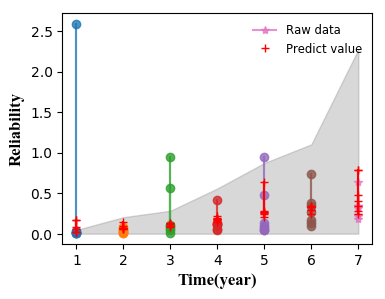

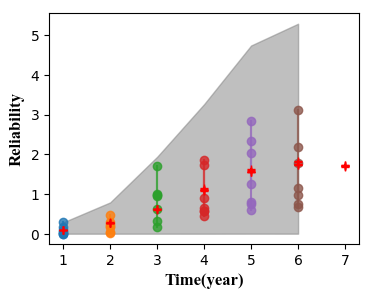

In [21]:
post_pred = np.loadtxt('post_pred_model2b.csv',delimiter = ',')
yipred_mean = post_pred.mean(axis=0)
# np.savetxt('post_pred_model2b.csv',post_pred , delimiter=',')
sig0 = pm.hpd(post_pred, alpha=0.05)
# print(sig0)
# plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(4, 3))
# fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 0
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[:6,0], sig0[:6,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
plt.xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
# ax = plt.subplot(1, 1, 1)
ip = 1
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
plt.plot(xp, yp, marker='o', alpha=.8)
ax11, = plt.plot([7,7,7,7,7,7,7], [0.177,0.236,0.213,0.315,0.339,0.635,0.336], marker='*', alpha=.8)

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
# print(yipred_yplot)
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
plt.plot(xipred, yipred_yplot[:], 'k+-', color='r')
ax22, = plt.plot(xipred[0], yipred_yplot[0], 'k+', color='r')
plt.fill_between(xipred[0], sig0[42:49,0], sig0[42:49,1], color='gray', alpha=.3)

plt.xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
plt.legend([ax11,ax22], ['Raw data', 'Predict value'], loc='upper right', frameon=False, fontsize='small')
plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 2
xp = elec_year2[ip * 7:(ip + 1) * 7, :]  # 原始数据
yp = elec_faults2[ip * 7:(ip + 1) * 7, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp[0], sig0[84:90,0], sig0[84:90,1], color='gray', alpha=.5)  

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(6*ip, (ip+1)*6)])
xipred = np.array([np.arange(7)+1 for i in np.arange(6)])
plt.xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
plt.show()